In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
path='./data/v3/'

users = pd.read_csv(path+'users.csv')
books = pd.read_csv(path+'books.csv')
ratings = pd.read_csv(path+'train_ratings.csv')
test_ratings = pd.read_csv(path+'test_ratings.csv')

print('users shape: ', users.shape)
print('books shape: ', books.shape)
print('ratings shape: ', ratings.shape)
print('test_ratings shape:', test_ratings.shape)

users shape:  (68092, 6)
books shape:  (149570, 11)
ratings shape:  (306795, 3)
test_ratings shape: (76699, 3)


## 1st EDA

### users

In [5]:
users.head()

,user_id,location,age
0,8,"timmins, ontario, canada",NaN
1,11400,"ottawa, ontario, canada",49.0
2,11676,"n/a, n/a, n/a",NaN
3,67544,"toronto, ontario, canada",30.0
4,85526,"victoria, british columbia, canada",36.0


In [6]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   68092 non-null  int64  
 1   location  68092 non-null  object 
 2   age       40259 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ MB


In [7]:
users.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,68092.0,139381.329539,80523.969862,8.0,69008.75,138845.5,209388.25,278854.0
age,40259.0,36.069873,13.842571,5.0,25.00,34.0,45.00,99.0


In [8]:
users.isna().sum() / len(users)

user_id     0.000000
location    0.000000
age         0.408756
dtype: float64

In [9]:
users['location'] = users['location'].str.replace(r'[^0-9a-zA-Z:,]', '') # 특수문자 제거

users['location_city'] = users['location'].apply(lambda x: x.split(',')[0].strip())
users['location_state'] = users['location'].apply(lambda x: x.split(',')[1].strip())
users['location_country'] = users['location'].apply(lambda x: x.split(',')[2].strip())

users = users.replace('na', np.nan) #특수문자 제거로 n/a가 na로 바뀌게 되었습니다. 따라서 이를 컴퓨터가 인식할 수 있는 결측값으로 변환합니다.
users = users.replace('', np.nan) # 일부 경우 , , ,으로 입력된 경우가 있었으므로 이런 경우에도 결측값으로 변환합니다.

In [10]:
users.isna().sum()

user_id                 0
location                0
age                 27833
location_city          25
location_state       1818
location_country     2111
dtype: int64

In [11]:
modify_location = users[(users['location_country'].isna())&(users['location_city'].notnull())]['location_city'].values

location_list = []
for location in modify_location:
    try:
        right_location = users[(users['location'].str.contains(location)) & (users['location_state'].notnull()) & (users['location_country'].notnull())]['location'].value_counts().index[0]
        location_list.append(right_location)
    except:
        pass

/tmp/ipykernel_5188/191084157.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  right_location = users[(users['location'].str.contains(location)) & (users['location_state'].notnull()) & (users['location_country'].notnull())]['location'].value_counts().index[0]
/tmp/ipykernel_5188/191084157.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  right_location = users[(users['location'].str.contains(location)) & (users['location_state'].notnull()) & (users['location_country'].notnull())]['location'].value_counts().index[0]


In [12]:
for location in location_list:
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_state'] = location.split(',')[1].strip()
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_country'] = location.split(',')[2].strip()

In [13]:
users['location_country'].value_counts()

location_country
usa                     45184
canada                   6549
germany                  3602
united kingdom           3147
australia                1841
                        ...  
alderney                    1
district of columbia        1
west indies                 1
kosovo                      1
nz                          1
Name: count, Length: 294, dtype: int64

In [14]:
users.isna().sum()

user_id                 0
location                0
age                 27833
location_city          25
location_state        353
location_country      266
dtype: int64

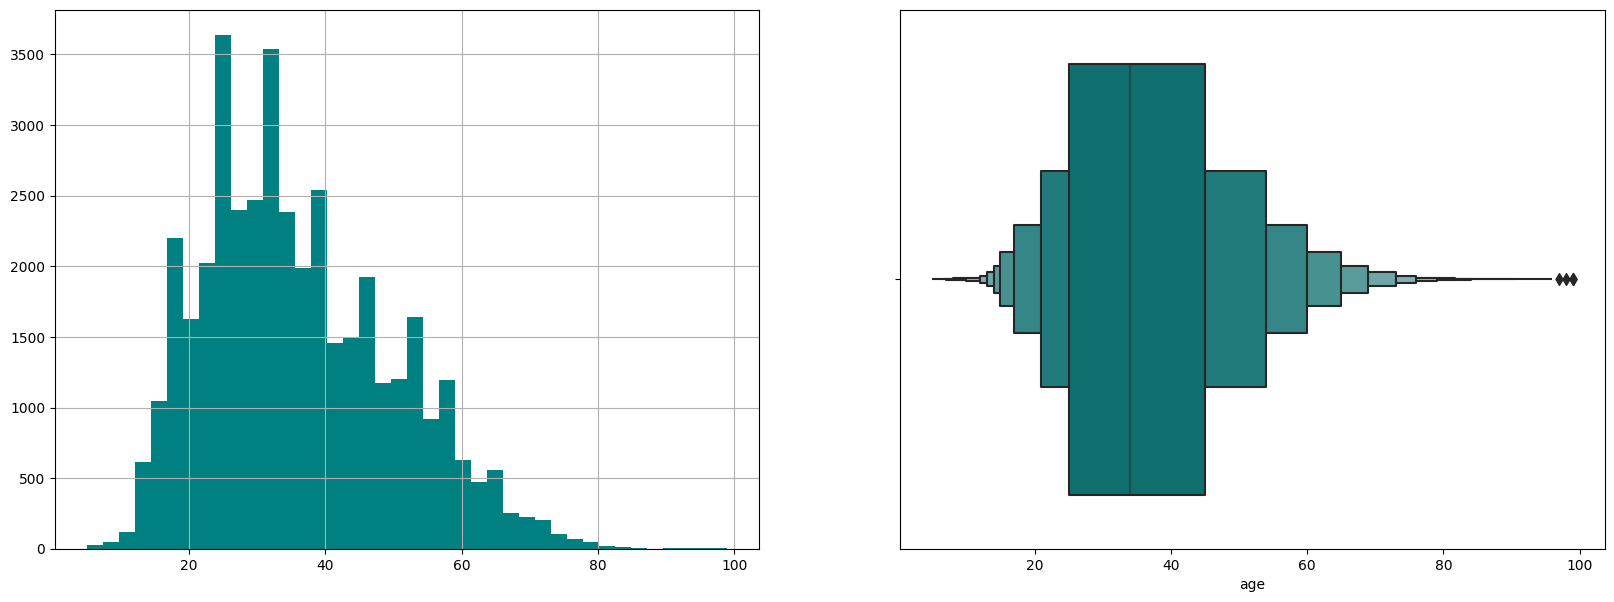

In [15]:
# 나이 분포
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

users['age'].hist(bins=40, color='teal', ax=ax[0])
sns.boxenplot(data=users, x='age', color='teal',ax=ax[1])

plt.show()

In [16]:
users['age'].value_counts()

age
29.0    1290
26.0    1250
25.0    1243
34.0    1215
27.0    1207
        ... 
86.0       1
94.0       1
89.0       1
98.0       1
92.0       1
Name: count, Length: 91, dtype: int64

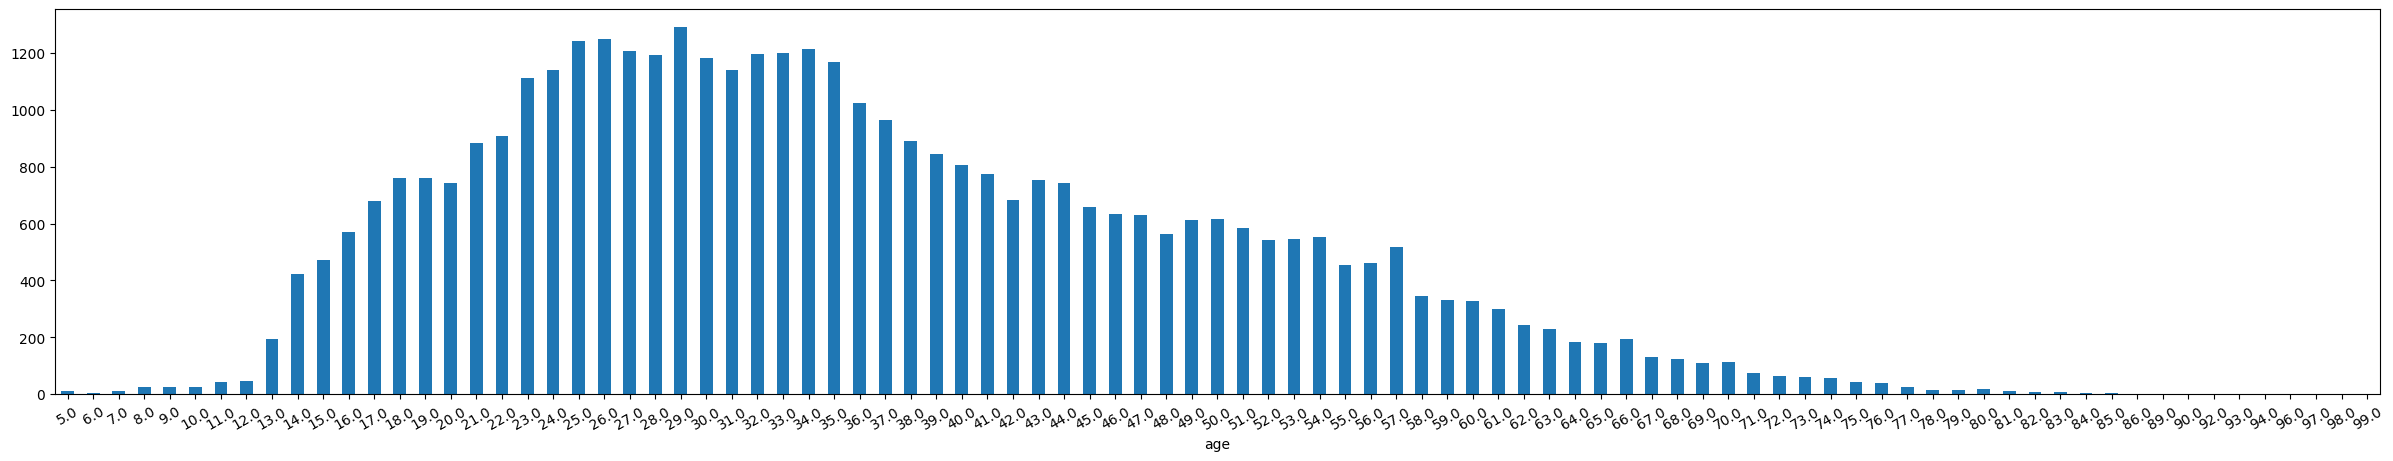

In [17]:
plt.figure(figsize=(30,5))
users['age'].value_counts().sort_index().plot(kind='bar')
plt.xticks(rotation=30)
plt.show()

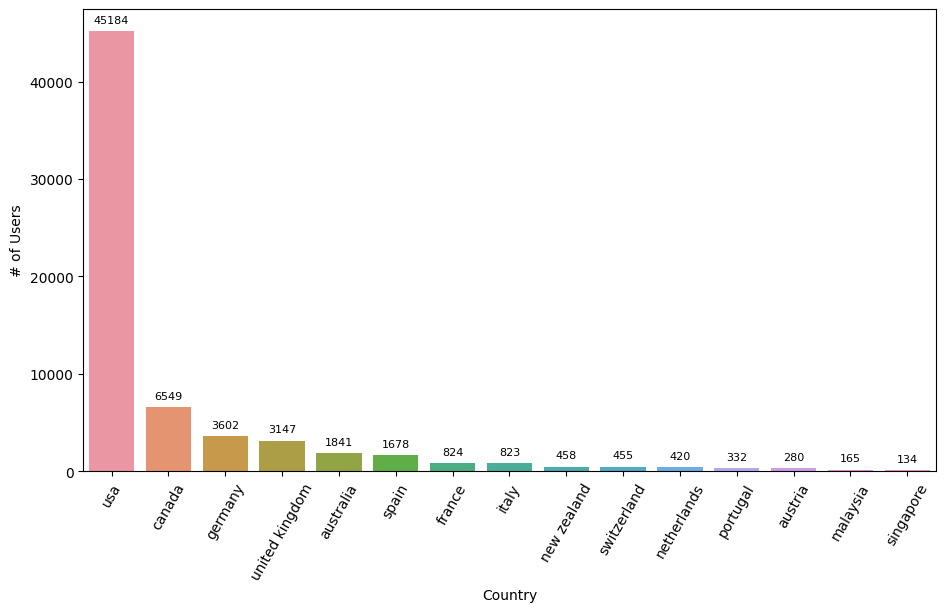

In [18]:
my_dict=(users['location_country'].value_counts()).to_dict()
count= pd.DataFrame(list(my_dict.items()),columns = ['location_country','count'])
f = count.sort_values(by=['count'], ascending = False)
f = f.head(15)
# f.drop(7,inplace=True)
fig=plt.figure(figsize=(11,6))
ax = sns.barplot(y = 'count',x= 'location_country' , data = f)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60,horizontalalignment='center')
for bar in ax.patches: 
    ax.annotate(format(bar.get_height(), '.0f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=8, xytext=(0,8), 
                   textcoords='offset points') 

plt.xlabel("Country", size=10)
plt.ylabel("# of Users", size=10)
plt.show()

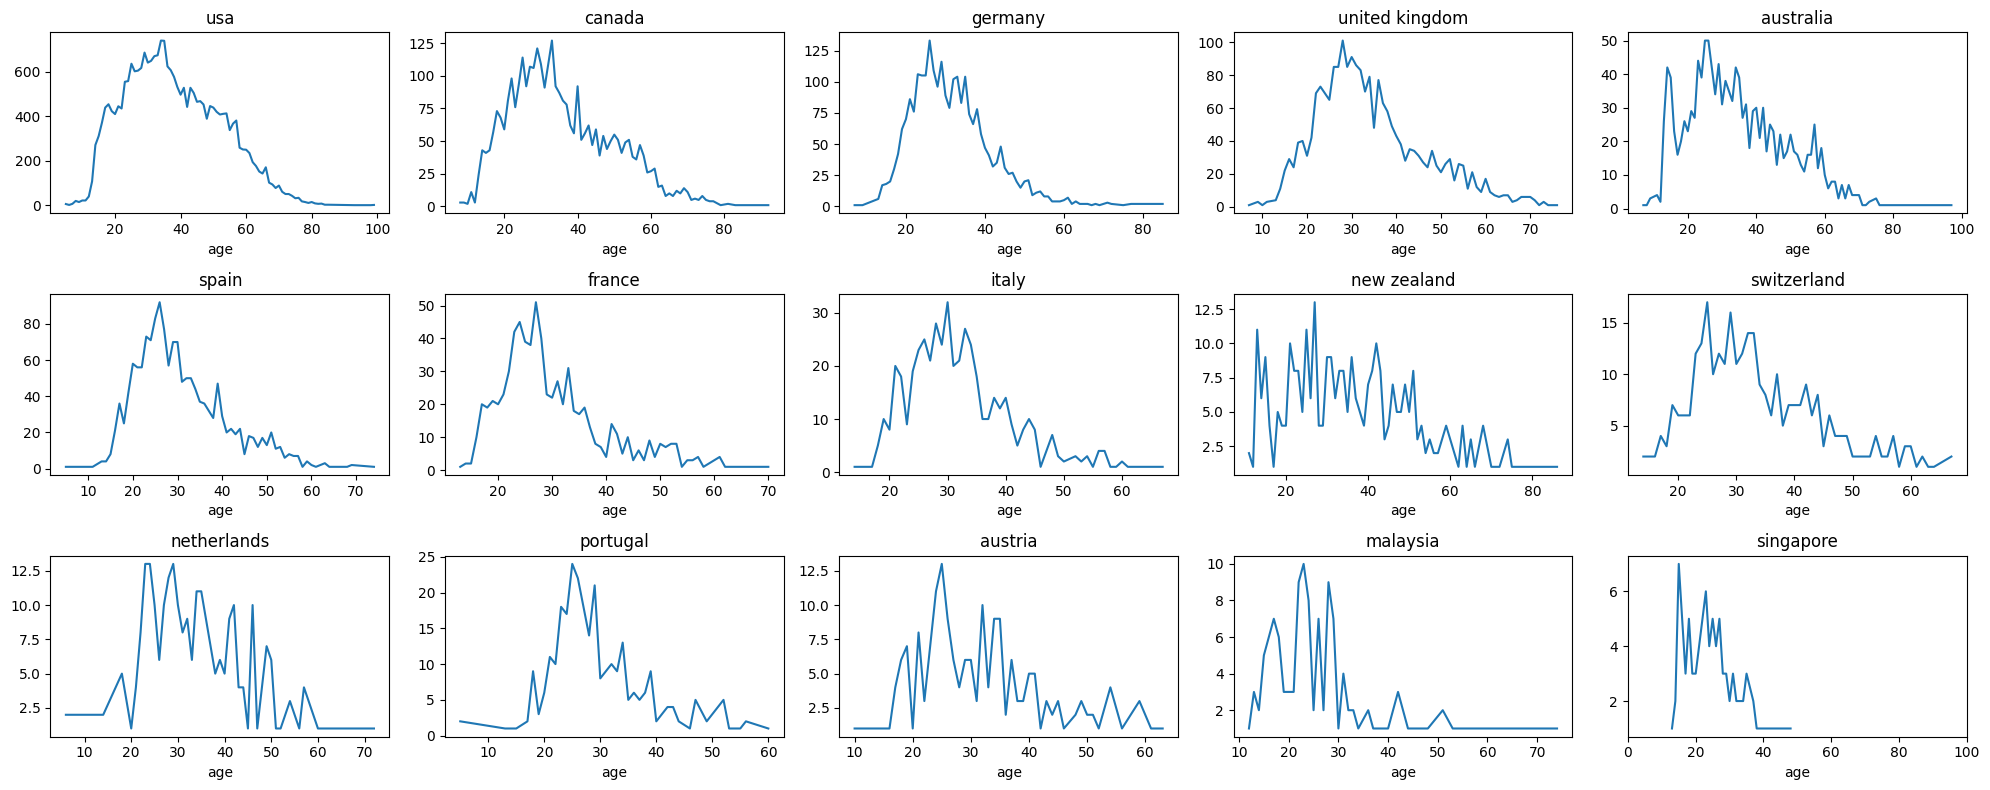

In [19]:
fig, ax = plt.subplots(3,5,figsize=(20,8))
for country, ax_ in zip(f['location_country'], ax.flatten()):
    users[(users['location_country']==country)]['age'].value_counts().sort_index().plot(ax=ax_, title=country)
plt.xlim(0,100)
plt.tight_layout()
plt.show()

In [20]:
users[users['age'].isna()]['location_country'].value_counts()

location_country
usa                   20211
canada                 3146
germany                1105
united kingdom          957
australia               481
                      ...  
republic of panama        1
uk                        1
latvia                    1
auckland                  1
macedonia                 1
Name: count, Length: 191, dtype: int64

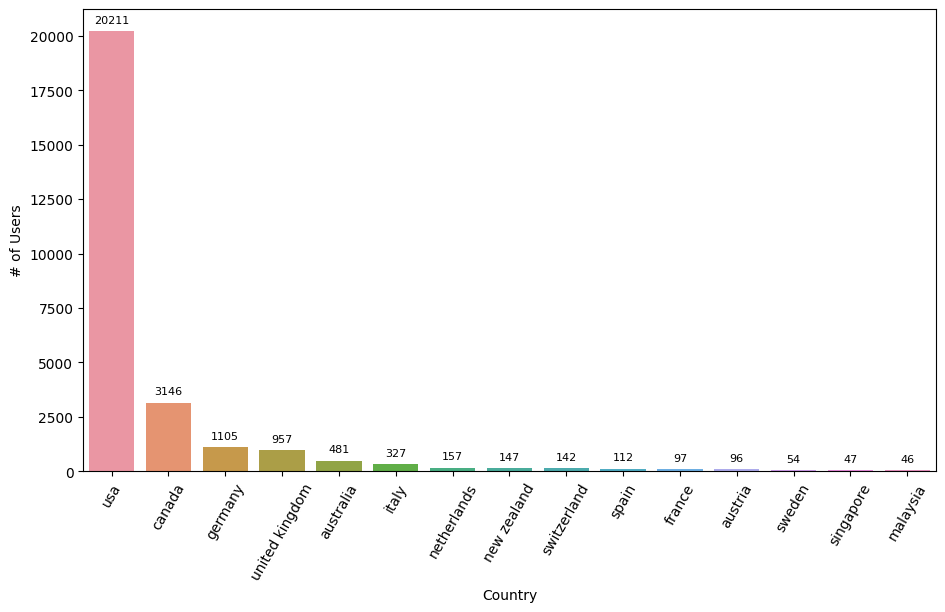

In [21]:
my_dict=(users[users['age'].isna()]['location_country'].value_counts()).to_dict()
count= pd.DataFrame(list(my_dict.items()),columns = ['location_country','count'])
f = count.sort_values(by=['count'], ascending = False)
f = f.head(15)
fig=plt.figure(figsize=(11,6))
ax = sns.barplot(y = 'count',x= 'location_country' , data = f)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60,horizontalalignment='center')
for bar in ax.patches: 
    ax.annotate(format(bar.get_height(), '.0f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=8, xytext=(0,8), 
                   textcoords='offset points') 

plt.xlabel("Country", size=10)
plt.ylabel("# of Users", size=10)
plt.show()

### book

In [22]:
books.shape

(149570, 10)

In [23]:
books['isbn'].nunique()

149570

In [24]:
books['book_title'].nunique()

135436

In [25]:
books.head()

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
0,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['Actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
1,0060973129,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,en,['1940-1949'],"Here, for the first time in paperback, is an o...",images/0060973129.01.THUMBZZZ.jpg
2,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,en,['Medical'],"Describes the great flu epidemic of 1918, an o...",images/0374157065.01.THUMBZZZ.jpg
3,0399135782,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,en,['Fiction'],A Chinese immigrant who is convinced she is dy...,images/0399135782.01.THUMBZZZ.jpg
4,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000.0,Berkley Publishing Group,http://images.amazon.com/images/P/0425176428.0...,en,['History'],"Essays by respected military historians, inclu...",images/0425176428.01.THUMBZZZ.jpg


In [26]:
books.isna().sum()

isbn                       0
book_title                 0
book_author                1
year_of_publication        0
publisher                  0
img_url                    0
language               67227
category               68851
summary                67227
img_path                   0
dtype: int64

In [27]:
books[books['language'].isna() & books['summary'].notnull()]
books[books['language'].notnull() & books['summary'].isna()]
books[books['language'].isna() & books['category'].notnull()]

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path


In [28]:
books[books['language'].notnull() & books['category'].isna()] 

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
138,2070567842,Folio Junior: L'histoire De Monsieur Sommer,Su>skind-Sempe,1994.0,Gallimard-Jeunesse,http://images.amazon.com/images/P/2070567842.0...,fr,NaN,Un petit garçon se pose énormément de question...,images/2070567842.01.THUMBZZZ.jpg
193,3596292646,Das Buch der lÃ?Â¤cherlichen Liebe.,Milan Kundera,2000.0,"Fischer (Tb.), Frankfurt",http://images.amazon.com/images/P/3596292646.0...,de,NaN,Die im &#39;Buch der lächerlichen Liebe&#39; v...,images/3596292646.01.THUMBZZZ.jpg
486,0871131811,Zodiac: The Eco-Thriller,Neal Stephenson,1988.0,Pub Group West,http://images.amazon.com/images/P/0871131811.0...,en,NaN,"Sangamon Taylor, an environmental extremist, s...",images/0871131811.01.THUMBZZZ.jpg
880,067144378X,SABLE MOON,Nancy Springer,1981.0,Pocket,http://images.amazon.com/images/P/067144378X.0...,en,NaN,Seventeen-year-old Prince Trevyn must save the...,images/067144378X.01.THUMBZZZ.jpg
1001,0345339711,"The Two Towers (The Lord of the Rings, Part 2)",J.R.R. TOLKIEN,1986.0,Del Rey,http://images.amazon.com/images/P/0345339711.0...,en,NaN,"Thus continues the magnificent, bestselling ta...",images/0345339711.01.THUMBZZZ.jpg
...,...,...,...,...,...,...,...,...,...,...
149252,3770401697,"Lucky Luke, Bd.58, Die Geister-Ranch und ander...",Michel Janvier,1989.0,"Egmont Ehapa, Berlin",http://images.amazon.com/images/P/3770401697.0...,de,NaN,"Enth. noch: Die Hellseherin, Die Statue und Di...",images/3770401697.01.THUMBZZZ.jpg
149307,0806917695,Perplexing Lateral Thinking Puzzles: Scholasti...,Paul Sloane,1997.0,Sterling Publishing,http://images.amazon.com/images/P/0806917695.0...,en,NaN,"Normal situations veer off into the bizarre, c...",images/0806917695.01.THUMBZZZ.jpg
149329,3426192543,Im FrÃ?Â¼hling singt zum letztenmal die Lerche.,Johannes Mario Simmel,1990.0,Droemer Knaur,http://images.amazon.com/images/P/3426192543.0...,de,NaN,Eine Gruppe von Idealisten nimmt den Kampf geg...,images/3426192543.01.THUMBZZZ.jpg
149441,2253054615,Le maharani,Gita Mehta,1990.0,LGF,http://images.amazon.com/images/P/2253054615.0...,fr,NaN,Elevée à la cour comme toutes les maharani l&#...,images/2253054615.01.THUMBZZZ.jpg


In [29]:
books[books['isbn'] != books['img_url'].apply(lambda x: x.split('P/')[1][:10])]

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path


In [30]:
books[books['isbn']!=books['img_path'].apply(lambda x: x.split('images/')[1][:10])]

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path


In [31]:
publisher_dict=(books['publisher'].value_counts()).to_dict()
publisher_count_df= pd.DataFrame(list(publisher_dict.items()),columns = ['publisher','count'])

publisher_count_df = publisher_count_df.sort_values(by=['count'], ascending = False)

In [32]:
publisher_count_df.head()

,publisher,count
0,Harlequin,3005
1,Ballantine Books,2322
2,Pocket,2274
3,Penguin Books,1943
4,Bantam Books,1938


In [33]:
books['publisher'].nunique() # 수정전 항목 수를 확인합니다.

11571

In [34]:
modify_list = publisher_count_df[publisher_count_df['count']>1].publisher.values

In [35]:
for publisher in modify_list:
    try:
        number = books[books['publisher']==publisher]['isbn'].apply(lambda x: x[:4]).value_counts().index[0]
        right_publisher = books[books['isbn'].apply(lambda x: x[:4])==number]['publisher'].value_counts().index[0]
        books.loc[books[books['isbn'].apply(lambda x: x[:4])==number].index,'publisher'] = right_publisher
    except: 
        pass

In [36]:
books['publisher'].nunique() #수정 후 출판사 갯수입니다

1523

In [37]:
books['publisher'].value_counts()

publisher
Pocket                        7306
Harlequin                     5268
Bantam Books                  4815
St. Martin's Press            4043
Vintage Books USA             3822
                              ... 
Oh Editions                      1
Saur                             1
Rossmen                          1
Tascabili Economici Newton       1
Information                      1
Name: count, Length: 1523, dtype: int64

In [38]:
import re
books.loc[books[books['category'].notnull()].index, 'category'] = books[books['category'].notnull()]['category'].apply(lambda x: re.sub('[\W_]+',' ',x).strip())

In [39]:
books['category'].value_counts()

category
Fiction                                            32956
Juvenile Fiction                                    5804
Biography Autobiography                             3320
History                                             1925
Religion                                            1818
                                                   ...  
Eschatology                                            1
Dogsledding                                            1
Brenner Simon Fictitious character                     1
Gone with the wind Motion picture 1939                 1
Authors Canadian English 20th century Biography        1
Name: count, Length: 4137, dtype: int64

In [40]:
books['category'] = books['category'].str.lower()

In [41]:
books['category'].value_counts()

category
fiction                                            33016
juvenile fiction                                    5835
biography autobiography                             3326
history                                             1927
religion                                            1818
                                                   ...  
brenner simon fictitious character                     1
gone with the wind motion picture 1939                 1
disguise                                               1
country lawyers                                        1
authors canadian english 20th century biography        1
Name: count, Length: 4105, dtype: int64

In [42]:
category_df = pd.DataFrame(books['category'].value_counts()).reset_index()
category_df.columns = ['category','count']
category_df

,category,count
0,fiction,33016
1,juvenile fiction,5835
2,biography autobiography,3326
3,history,1927
4,religion,1818
...,...,...
4100,brenner simon fictitious character,1
4101,gone with the wind motion picture 1939,1
4102,disguise,1
4103,country lawyers,1


In [43]:
from collections import defaultdict

categories = defaultdict(int)

for category in category_df['category']:
    cs = category.split()
    for c in cs:
        categories[c] += 1

common_category = []
for k, v in categories.items():
    if v >= 10 and len(k) > 3:
        common_category.append(k)

common_category.append('law')
common_category.append('art')
common_category.append('man')
common_category.append('gay')
common_category.append('men')
common_category.append('war')
common_category.append('god')
common_category.append('dog')
common_category.append('cat')
common_category.append('sex')

print(common_category)

# law art man gay men war god dog cat sex

['fiction', 'social', 'science', 'humor', 'body', 'business', 'cooking', 'family', 'self', 'psychology', 'poetry', 'philosophy', 'drama', 'arts', 'language', 'education', 'music', 'detective', 'mystery', 'stories', 'children', 'photography', 'animals', 'adventure', 'american', 'english', 'christian', 'life', 'england', 'fantasy', 'german', 'authors', 'african', 'americans', 'france', 'french', 'literature', 'books', 'motion', 'picture', 'child', 'indians', 'germany', 'cookery', 'australian', 'short', 'behavior', 'canadian', 'medicine', '1945', 'imaginary', 'place', 'computer', 'fictitious', 'character', 'women', 'electronic', 'calif', 'spanish', 'communication', 'characters', 'school', 'human', 'program', 'animal', 'mythology', 'ethics', 'culture', 'management', 'greek', 'book', 'portuguese', 'game', 'films', 'texts', 'chinese', 'trade', 'geschichte', 'belletristische', 'darstellung', 'television', 'industry', 'black', 'programs', 'law', 'art', 'man', 'gay', 'men', 'war', 'god', 'dog',

In [44]:
for category in common_category:
    books.loc[books[books['category'].str.contains(category,na=False)].index,'category_high'] = category

category_high_df = pd.DataFrame(books['category_high'].value_counts()).reset_index()
category_high_df.columns = ['category','count']
category_high_df

,category,count
0,fiction,40551
1,science,2381
2,art,1581
3,humor,1166
4,body,1123
...,...,...
76,imaginary,8
77,gay,7
78,geschichte,5
79,mystery,3


In [45]:
books['category'].nunique()

4105

In [46]:
books['category_high'].nunique()

81

In [47]:
books.loc[books[books['category'].notna() & books['category_high'].isna()].index, 'category_high']='others'

In [48]:
books.isna().sum()

isbn                       0
book_title                 0
book_author                1
year_of_publication        0
publisher                  0
img_url                    0
language               67227
category               68851
summary                67227
img_path                   0
category_high          68851
dtype: int64

In [49]:
import matplotlib.pyplot as plt
from PIL import Image
import requests


In [50]:
books['img_url'][263]

'http://images.amazon.com/images/P/0804117934.01.THUMBZZZ.jpg'

In [51]:
books['img_url'][262]

'http://images.amazon.com/images/P/0803251718.01.THUMBZZZ.jpg'

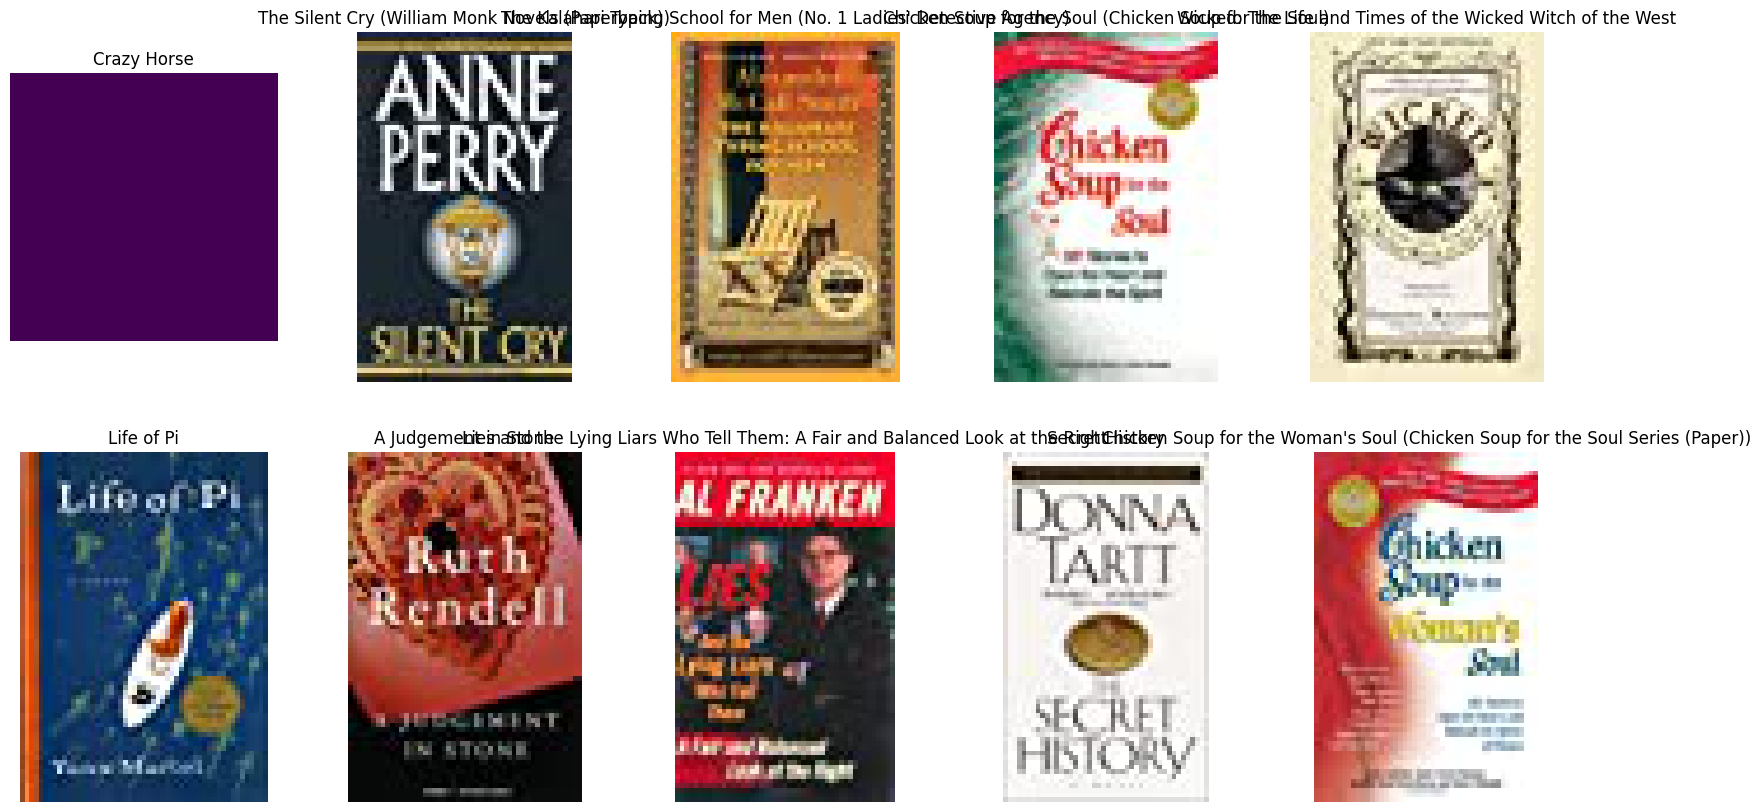

In [52]:
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
for i, ax in zip(range(262, 272), ax.flatten()):
    url = books['img_url'][i]
    img = np.asarray(Image.open(requests.get(url, stream=True, headers={
                     "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}).raw))
    ax.imshow(img)
    ax.axis("off")

    ax.set_title(books['book_title'][i])

fig.show()


In [53]:
import os


In [54]:
image_path = './data/'
file_path = image_path+books['img_path'][262]
file_path


'./data/images/0803251718.01.THUMBZZZ.jpg'

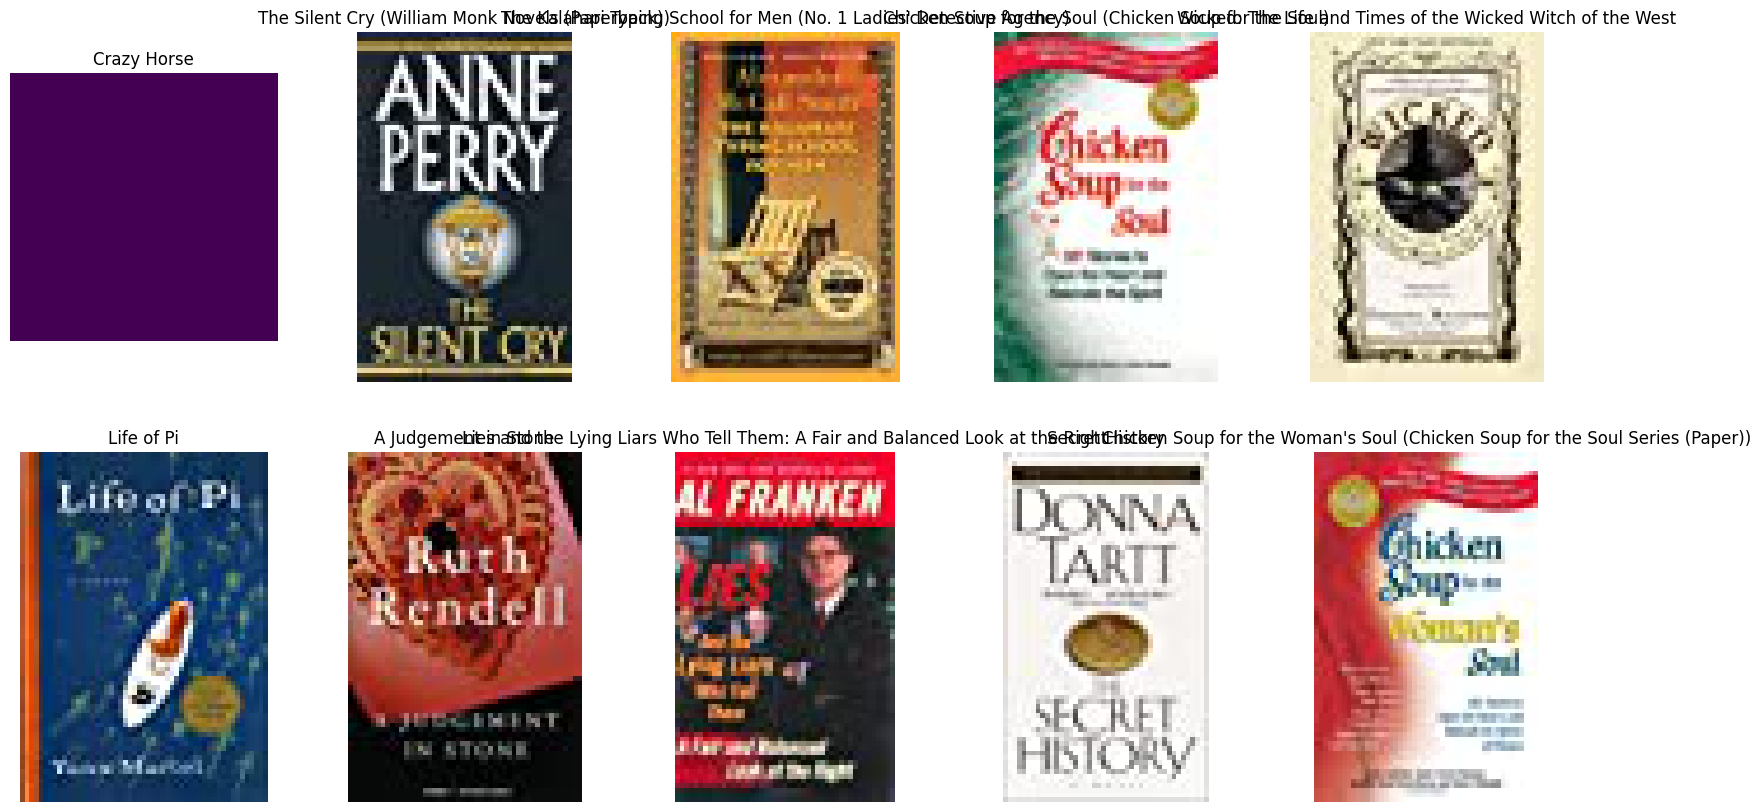

In [55]:
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
image_path = './data/'
for i, ax in zip(range(262, 272), ax.flatten()):
    file_path = image_path+books['img_path'][i]
    img = np.asarray(Image.open(file_path))
    ax.imshow(img)
    ax.axis("off")

    ax.set_title(books['book_title'][i])

fig.show()

In [56]:
books['publisher'].value_counts()

publisher
Pocket                        7306
Harlequin                     5268
Bantam Books                  4815
St. Martin's Press            4043
Vintage Books USA             3822
                              ... 
Oh Editions                      1
Saur                             1
Rossmen                          1
Tascabili Economici Newton       1
Information                      1
Name: count, Length: 1523, dtype: int64

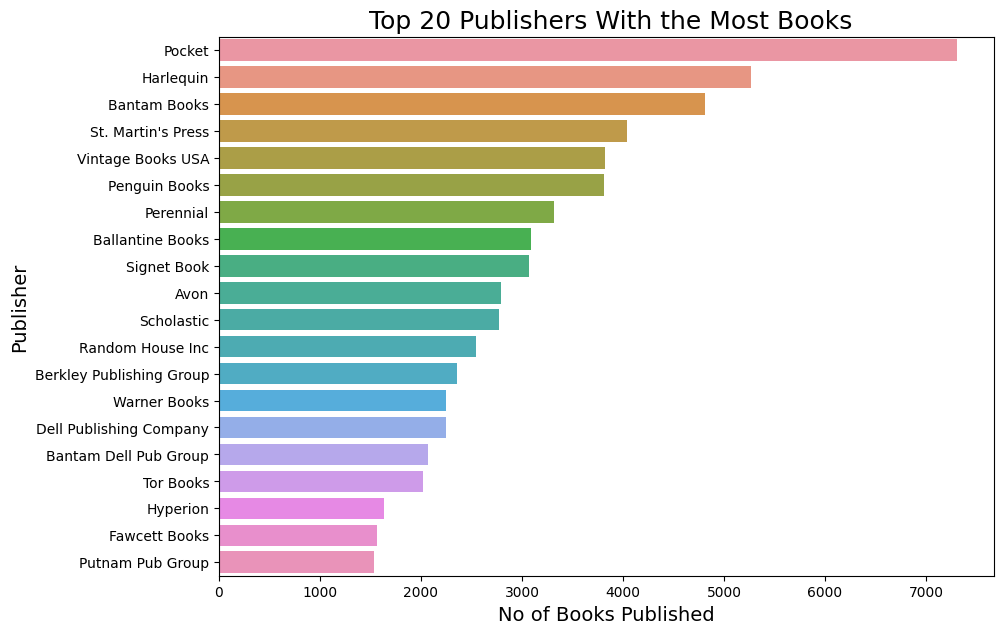

In [57]:
publisher_dict=(books['publisher'].value_counts()).to_dict()
publisher_count_df= pd.DataFrame(list(publisher_dict.items()),columns = ['publisher','count'])

b = publisher_count_df.sort_values(by=['count'], ascending = False)
b = b.head(20)

fig=plt.figure(figsize=(10,7))
ax = sns.barplot(x = 'count',y = 'publisher' , data = b)

plt.xlabel("No of Books Published", size=14)
plt.ylabel("Publisher", size=14)
plt.title(" Top 20 Publishers With the Most Books", size=18)

plt.show()

In [58]:
print(sorted(books['year_of_publication'].unique()),end=' ')

[1376.0, 1378.0, 1806.0, 1900.0, 1901.0, 1902.0, 1904.0, 1906.0, 1908.0, 1911.0, 1920.0, 1923.0, 1924.0, 1925.0, 1926.0, 1927.0, 1928.0, 1929.0, 1930.0, 1931.0, 1932.0, 1933.0, 1934.0, 1935.0, 1936.0, 1937.0, 1938.0, 1939.0, 1940.0, 1941.0, 1942.0, 1943.0, 1944.0, 1945.0, 1946.0, 1947.0, 1948.0, 1949.0, 1950.0, 1951.0, 1952.0, 1953.0, 1954.0, 1955.0, 1956.0, 1957.0, 1958.0, 1959.0, 1960.0, 1961.0, 1962.0, 1963.0, 1964.0, 1965.0, 1966.0, 1967.0, 1968.0, 1969.0, 1970.0, 1971.0, 1972.0, 1973.0, 1974.0, 1975.0, 1976.0, 1977.0, 1978.0, 1979.0, 1980.0, 1981.0, 1982.0, 1983.0, 1984.0, 1985.0, 1986.0, 1987.0, 1988.0, 1989.0, 1990.0, 1991.0, 1992.0, 1993.0, 1994.0, 1995.0, 1996.0, 1997.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0] 

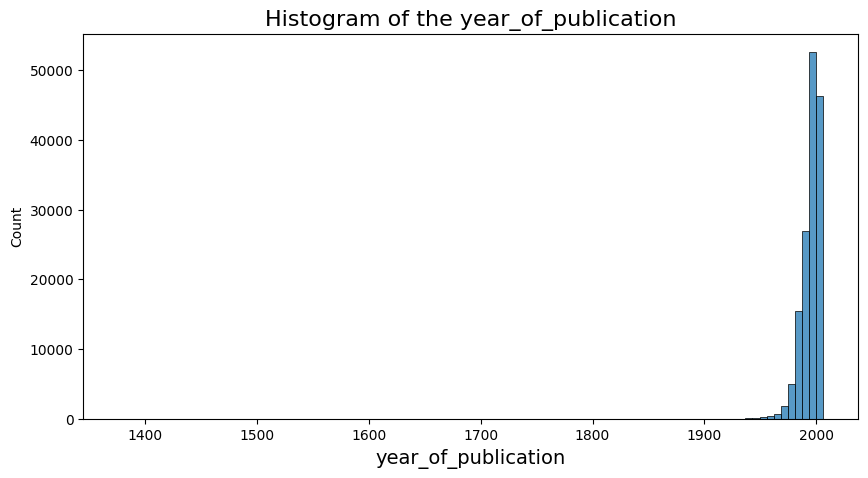

In [59]:
plt.figure(figsize=(10,5))
sns.histplot(books['year_of_publication'],bins=100)
plt.xlabel('year_of_publication',size=14)
plt.title('Histogram of the year_of_publication',size=16)
plt.show()

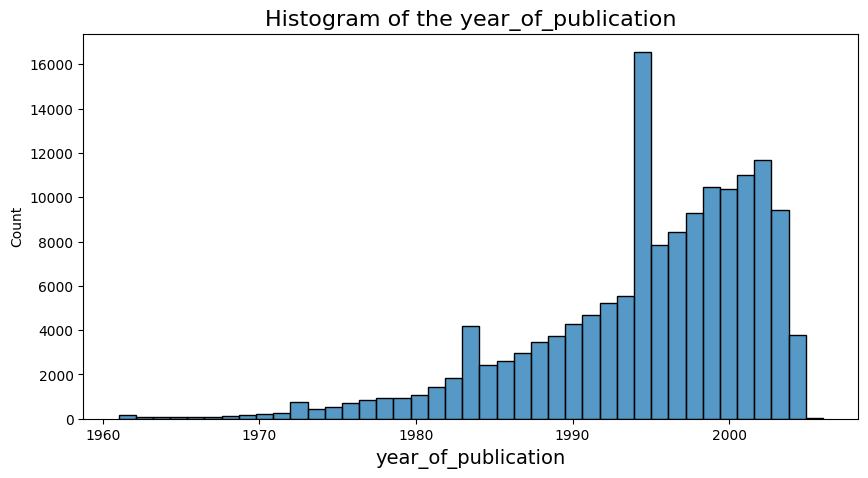

In [60]:
plt.figure(figsize=(10,5))
sns.histplot(books[books['year_of_publication']>1960]['year_of_publication'],bins=41)
plt.xlabel('year_of_publication',size=14)
plt.title('Histogram of the year_of_publication',size=16)
plt.show()

### Ratings

In [61]:
ratings.head()

,user_id,isbn,rating
0,8,0002005018,4
1,67544,0002005018,7
2,123629,0002005018,8
3,200273,0002005018,8
4,210926,0002005018,9


In [62]:
ratings['user_id'].nunique()

59803

In [63]:
ratings.shape

(306795, 3)

In [64]:
ratings['rating'].value_counts()

rating
8     73593
7     52928
9     48673
10    42774
6     25311
5     14111
1     13249
2     12929
4     12707
3     10520
Name: count, dtype: int64

In [65]:
ratings.groupby('user_id')['rating'].count().sort_values(ascending=False)

user_id
11676     5520
98391     4560
189835    1503
153662    1496
23902      956
          ... 
47317        1
150670       1
150676       1
150677       1
138957       1
Name: rating, Length: 59803, dtype: int64

In [66]:
heavy_users_list = ratings.groupby('user_id')['rating'].count().sort_values(ascending=False).head(20).index

In [67]:
ratings[ratings['user_id'].isin(heavy_users_list)].groupby('user_id')['rating'].mean()

user_id
11676     6.779891
16795     6.423684
23902     7.174686
35859     7.175896
56399     9.312036
76499     8.477778
95359     7.200820
98391     8.566228
101851    8.420354
114368    4.364389
153662    8.209893
158295    5.770270
171118    6.961089
177458    6.757794
182085    8.210269
185233    3.263914
189835    3.184298
197659    8.116170
235105    7.713054
248718    7.419009
Name: rating, dtype: float64

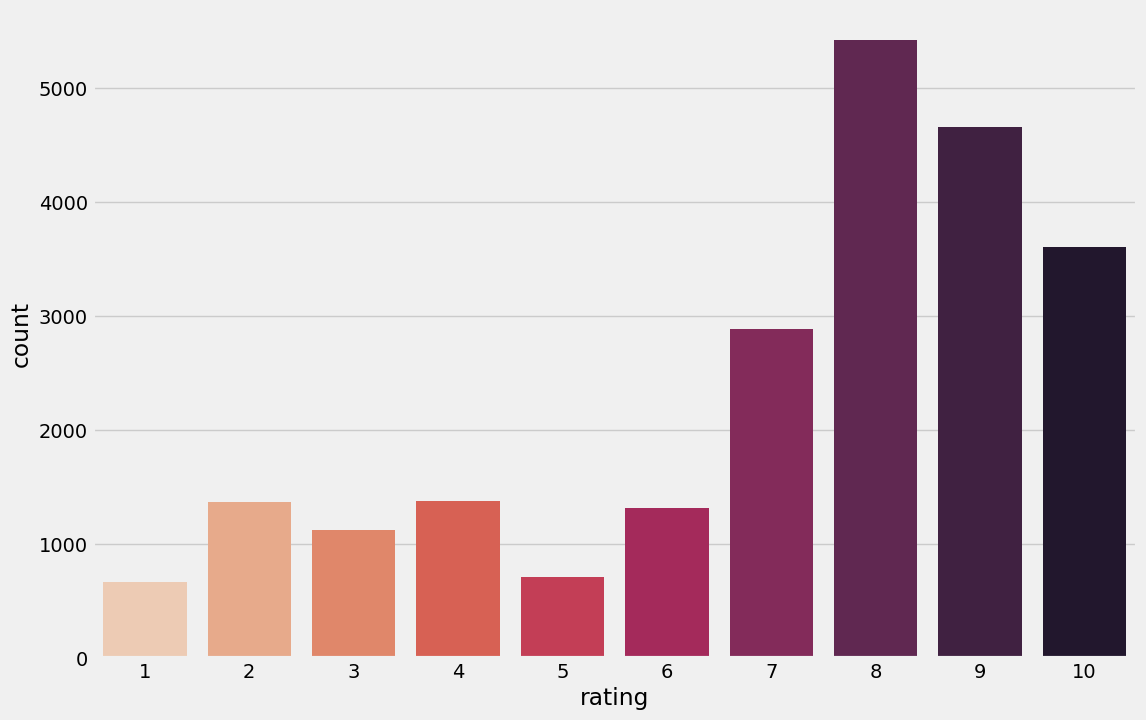

In [68]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.countplot(data=ratings[(ratings['user_id'].isin(heavy_users_list))] , x='rating', palette='rocket_r')
plt.show()

In [69]:
ratings.groupby('isbn')['rating'].count().sort_values(ascending=False)

isbn
0316666343    566
0971880107    465
0385504209    390
0312195516    307
0060928336    256
             ... 
0520060199      1
0520059808      1
0520058852      1
0520058763      1
B000234N3A      1
Name: rating, Length: 129777, dtype: int64

### Merge

In [70]:
merge1 = ratings.merge(books, how='left', on='isbn')
data = merge1.merge(users, how='inner', on='user_id')
print('merge 결과 shape: ', data.shape)

merge 결과 shape:  (306795, 18)


In [71]:
ratings.shape

(306795, 3)

In [72]:
set(ratings['isbn']) - set(books['isbn']) 

set()

In [73]:
popular_book_list = data['book_title'].value_counts().sort_values(ascending=False)[:30].index
popular_book = data[data['book_title'].isin(popular_book_list)]

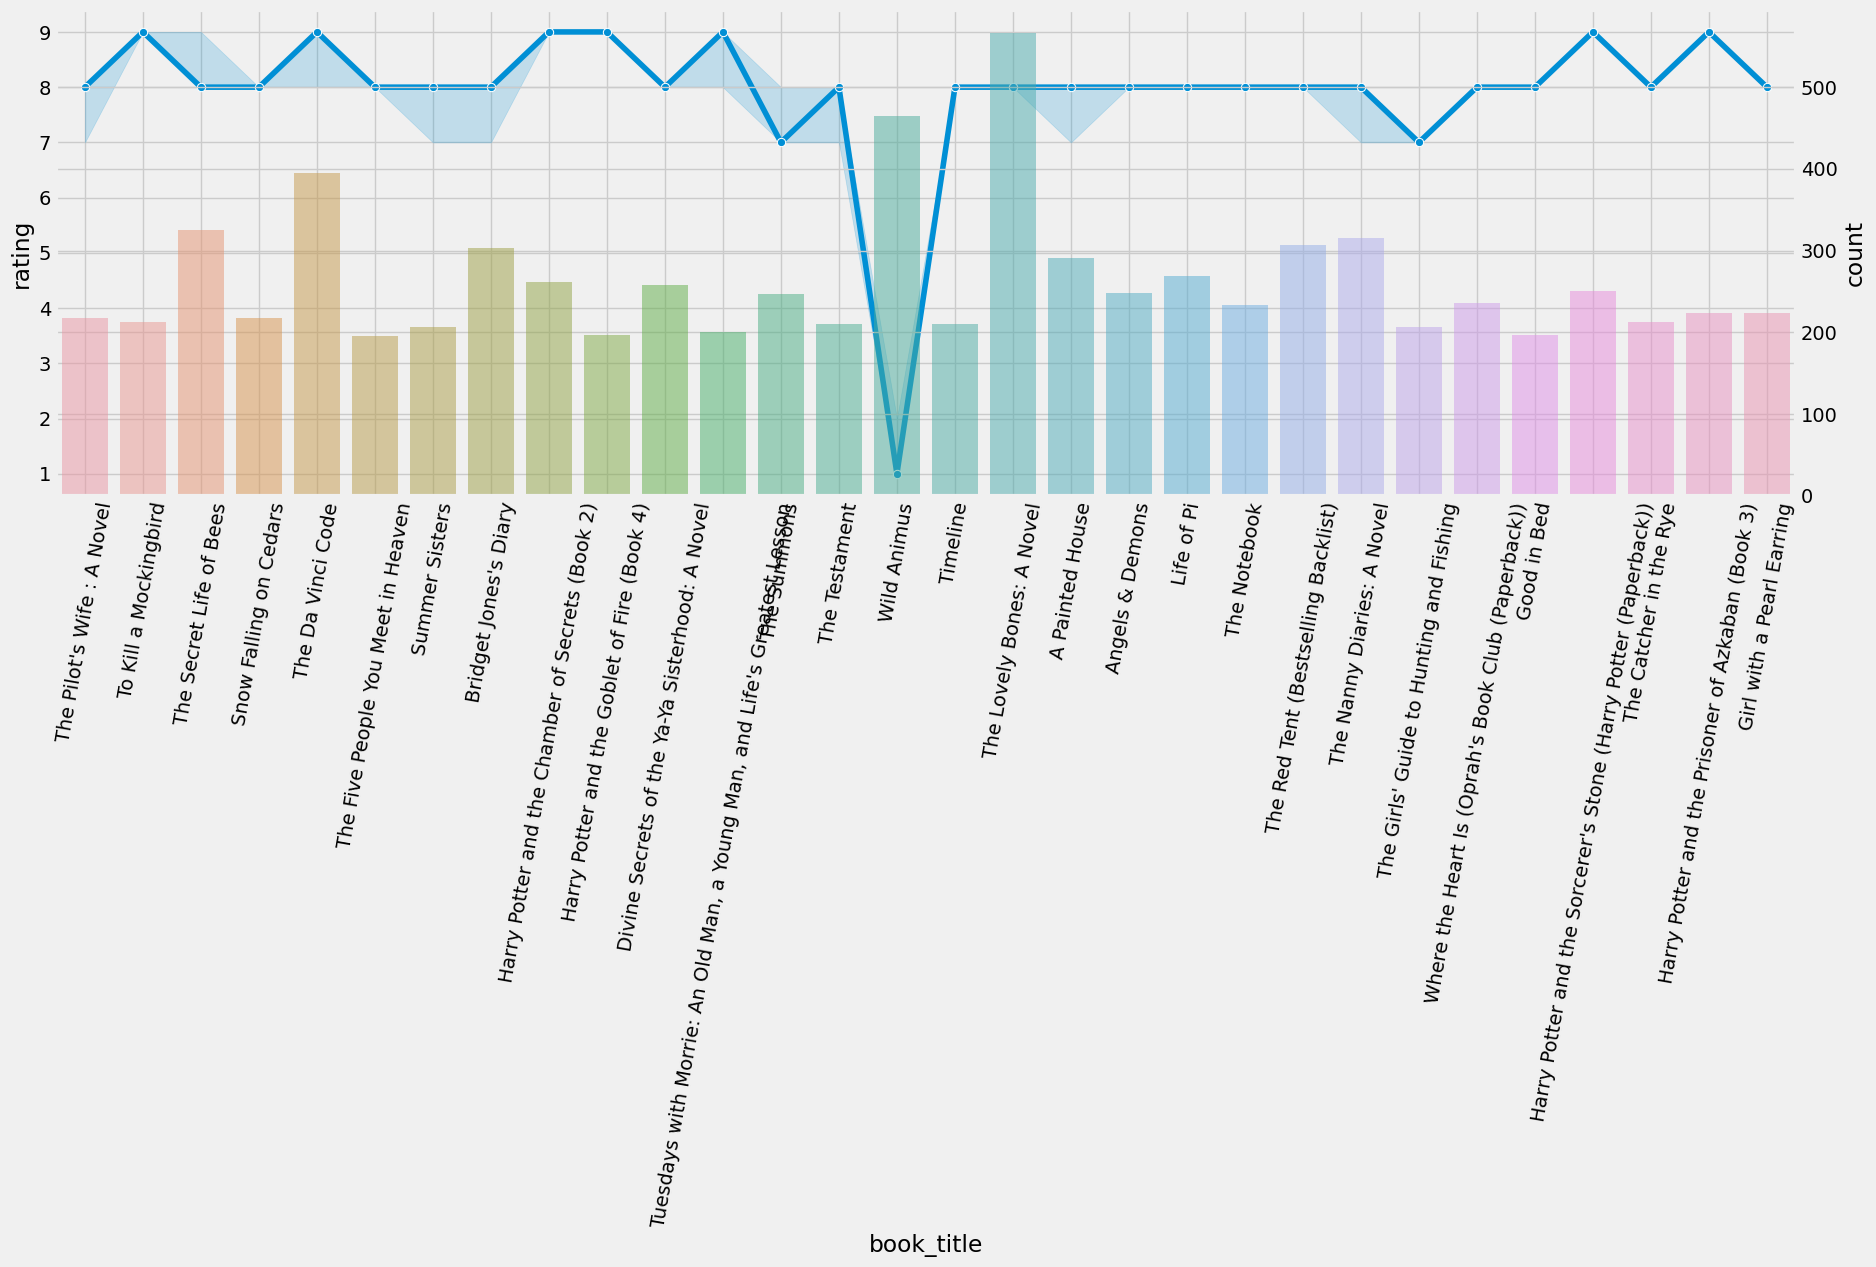

In [74]:
fig, ax1 = plt.subplots(figsize=(20,6))
plt.xticks(rotation=80)
sns.lineplot(data = popular_book,x='book_title',y='rating' ,marker='o', estimator=np.median, ax=ax1)
ax2 = ax1.twinx()

sns.countplot(data=popular_book, x='book_title', alpha=0.5, ax=ax2)
plt.show()

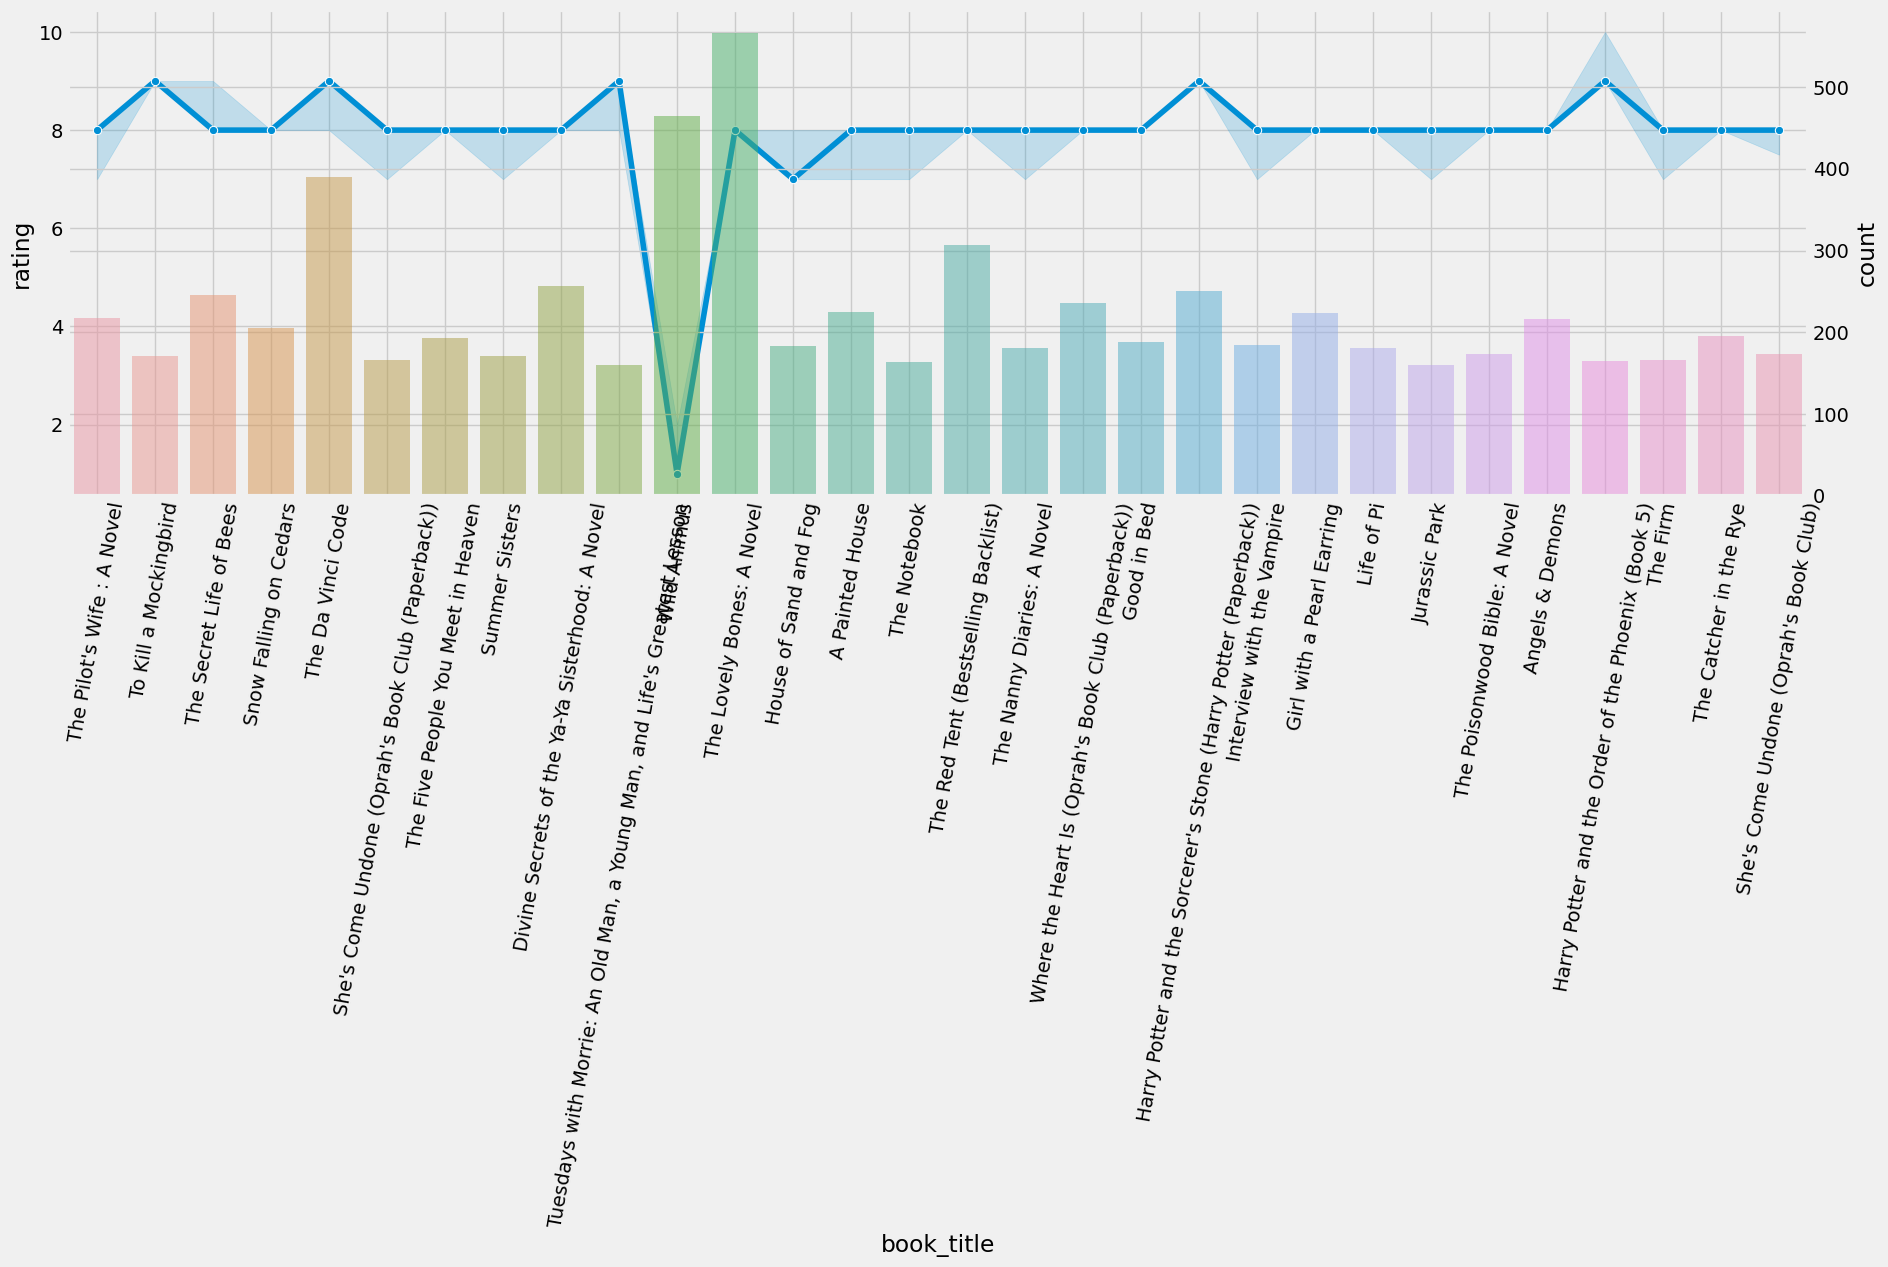

In [75]:
popular_book_list = data['isbn'].value_counts().sort_values(ascending=False)[:30].index
popular_book = data[data['isbn'].isin(popular_book_list)]

fig, ax1 = plt.subplots(figsize=(20,6))
plt.xticks(rotation=80)
sns.lineplot(data = popular_book,x='book_title',y='rating' ,marker='o', estimator=np.median, ax=ax1)
ax2 = ax1.twinx()

sns.countplot(data=popular_book, x='book_title', alpha=0.5, ax=ax2)
plt.show()

In [76]:
users['user_id'].corr(users['age'])

-0.0025844012309609995

### 데이터 파악

In [77]:
ratings.groupby('user_id')['rating'].count().sort_values(ascending=False)[:10]

user_id
11676     5520
98391     4560
189835    1503
153662    1496
23902      956
235105     812
76499      810
171118     771
16795      760
248718     747
Name: rating, dtype: int64

In [78]:
test_ratings.groupby('user_id')['rating'].count().sort_values(ascending=False)[:10]

user_id
11676     1419
98391     1125
189835     396
153662     347
23902      223
235105     208
76499      201
16795      198
248718     194
171118     189
Name: rating, dtype: int64

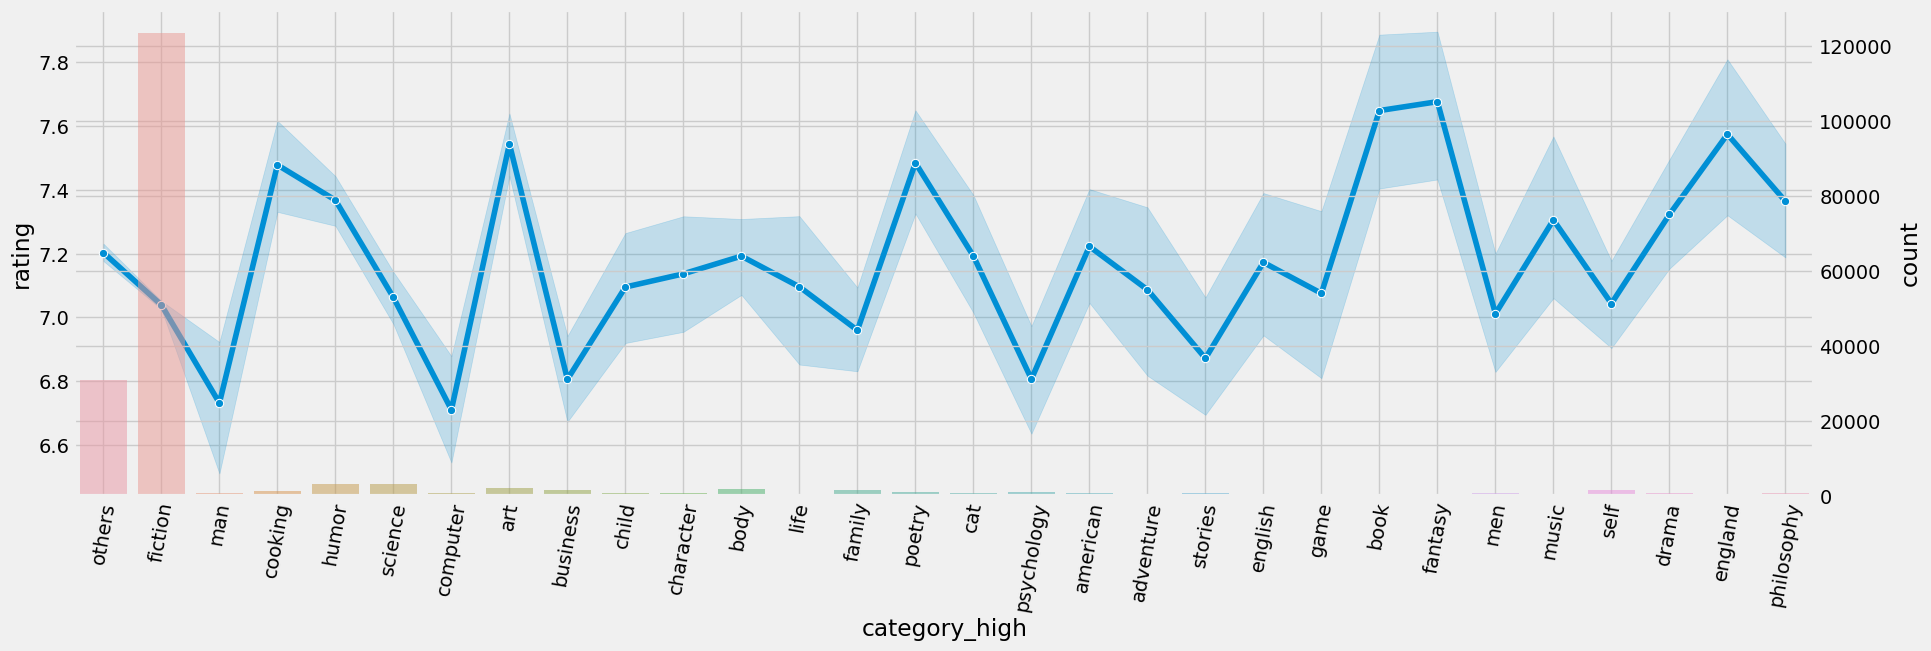

In [79]:
ch_data_list = data['category_high'].value_counts().sort_values(ascending=False)[:30].index
ch_data = data[data['category_high'].isin(ch_data_list)]

fig, ax1 = plt.subplots(figsize=(20,6))
plt.xticks(rotation=80)
sns.lineplot(data = ch_data ,x='category_high',y='rating' ,marker='o', estimator=np.mean, ax=ax1)
ax2 = ax1.twinx()

sns.countplot(data= ch_data, x='category_high', alpha=0.5, ax=ax2)
plt.show()

## 2nd EDA

### publisher 와 language 관계 이용하여 language 결측치 채우기

In [80]:
pub = books['publisher'].unique()

for p in pub:
    if not (books[(books['publisher'] == p) & (books['language'].notna())]['language'].value_counts().empty):
        books.loc[(books['publisher'] == p) & (books['language'].isna()), 'language'] = books[(books['publisher'] == p) & (books['language'].notna())]['language'].value_counts().index[0]

books[(books['publisher'].notna()) & (books['language'].isna())]['publisher'].value_counts()

publisher
GlÃ?Â©nat                         36
Unionsverlag                      27
Bruguera                          15
Egmont Franz Schneider Verlag     14
Hachette                          13
                                  ..
Walter De Gruyter Inc              1
Nicolai                            1
Knjizevna zajednica Novog Sada     1
Panamericana Pub Llc               1
Information                        1
Name: count, Length: 604, dtype: int64

In [81]:
books.isna().sum()


isbn                       0
book_title                 0
book_author                1
year_of_publication        0
publisher                  0
img_url                    0
language                1130
category               68851
summary                67227
img_path                   0
category_high          68851
dtype: int64

### ISBN 과 language 관계 이용하여 language 결측값 채우기

In [109]:
isbn2 = list(books['isbn'].str[:2].value_counts().index)

In [111]:
for i in isbn2:
    if not (books[books['isbn'].str[:2] == i]['language'].value_counts().empty):
        books.loc[(books['isbn'].str[:2] == i) & (books['language'].isna()), 'language'] = books[books['isbn'].str[:2] == i]['language'].value_counts().index[0]

In [113]:
books.loc[books['language'].isna(), 'language'] = books['language'].value_counts().index[0]

In [114]:
books.isna().sum()

isbn                       0
book_title                 0
book_author                1
year_of_publication        0
publisher                  0
img_url                    0
language                   0
category               68851
summary                67227
img_path                   0
category_high          68851
dtype: int64

In [117]:
books.to_csv(path+'v2/books.csv', index = False)

### MERGE

In [84]:
merge1 = ratings.merge(books, how='left', on='isbn')
data = merge1.merge(users, how='inner', on='user_id')
print('merge 결과 shape: ', data.shape)


merge 결과 shape:  (306795, 18)


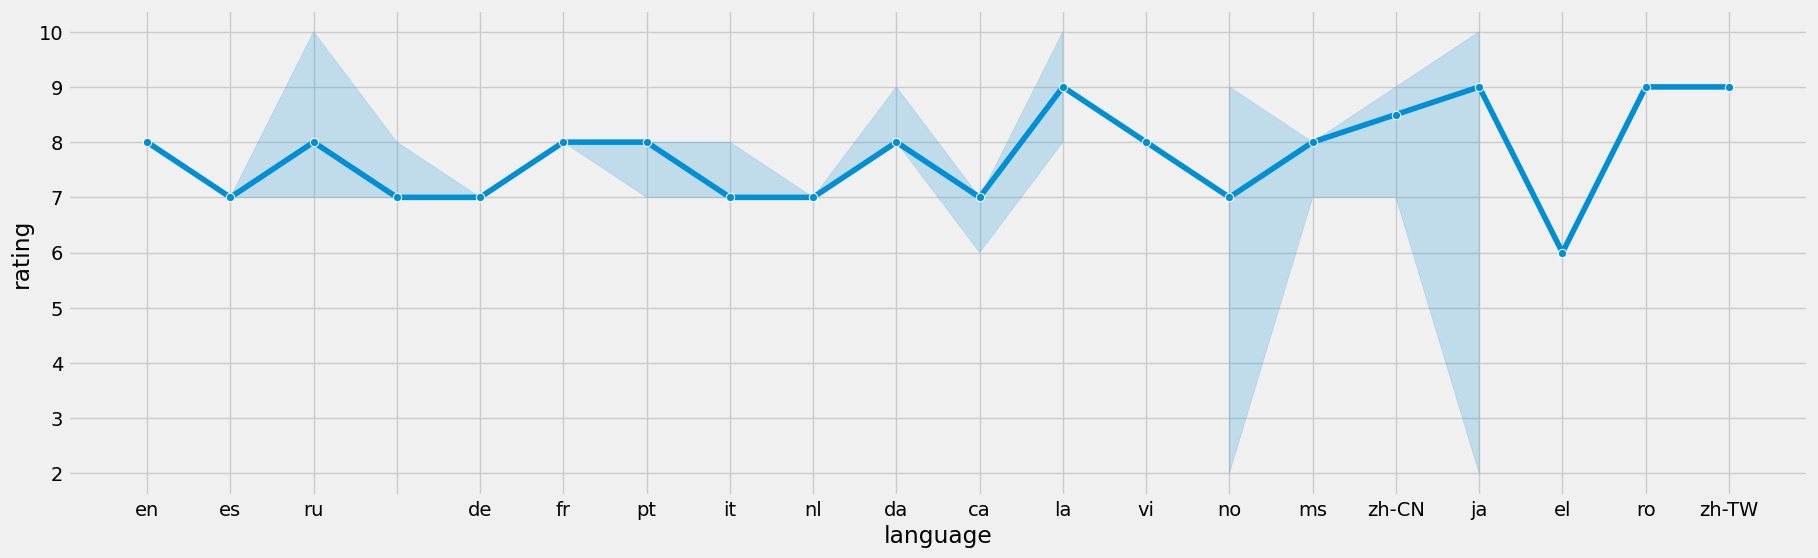

In [85]:
# 언어별 평점
popular_lang_list = data['language'].value_counts().sort_values(ascending=False)[:20].index
popular_lang = data[data['language'].isin(popular_lang_list)]

fig, ax1 = plt.subplots(figsize=(20, 6))
sns.lineplot(data=popular_lang, x='language', y='rating',
             marker='o', estimator=np.median, ax=ax1)
plt.show()


# 3rd EDA

books - ResNet18 을 이용하여 image 특징 추출한 뒤, 카테고리 채우기

In [6]:
import matplotlib.pyplot as plt
from PIL import Image
import requests

image_path = './data/'

for i in range(len(books)):
    file_path = image_path + books['img_path'][i]
    img = np.asarray(Image.open(file_path))
    if len(img) == 1:
        books.loc[books.index[i], 'img_path'] = np.NaN

In [7]:
books.isna().sum()

isbn                       0
book_title                 0
book_author                1
year_of_publication        0
publisher                  0
img_url                    0
language                   0
category               68851
summary                67227
img_path               41802
category_high          68851
dtype: int64

In [8]:
books[(books['img_path'].notna()) & (books['category'].notna())]

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path,category_high
0,0002005018,Clara Callan,Richard Bruce Wright,2001.0,Collins,http://images.amazon.com/images/P/0002005018.0...,en,actresses,"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg,others
2,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,en,medical,"Describes the great flu epidemic of 1918, an o...",images/0374157065.01.THUMBZZZ.jpg,others
4,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000.0,Berkley Publishing Group,http://images.amazon.com/images/P/0425176428.0...,en,history,"Essays by respected military historians, inclu...",images/0425176428.01.THUMBZZZ.jpg,others
6,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002.0,Pocket,http://images.amazon.com/images/P/074322678X.0...,en,fiction,"Now back in print, Ann Beattie&#39;s finest sh...",images/074322678X.01.THUMBZZZ.jpg,fiction
7,0771074670,Nights Below Station Street,David Adams Richards,1988.0,McClelland & Stewart,http://images.amazon.com/images/P/0771074670.0...,en,fiction,Another story based in the fictional rural tow...,images/0771074670.01.THUMBZZZ.jpg,fiction
...,...,...,...,...,...,...,...,...,...,...,...
149556,1896095186,Pool-Hopping,Anne Fleming,2000.0,Drawn & Quarterly,http://images.amazon.com/images/P/1896095186.0...,en,fiction,The fascinating characters in this short story...,images/1896095186.01.THUMBZZZ.jpg,fiction
149559,0449225208,The Christmas Spirit,Patricia Wynn,1996.0,Fawcett Books,http://images.amazon.com/images/P/0449225208.0...,en,fiction,"Taking human form as part of a wager, mischiev...",images/0449225208.01.THUMBZZZ.jpg,fiction
149563,0689818904,My Grandmother's Journey,John Cech,1998.0,Aladdin,http://images.amazon.com/images/P/0689818904.0...,en,juvenile fiction,A grandmother tells the story of her eventful ...,images/0689818904.01.THUMBZZZ.jpg,fiction
149566,0767907566,All Elevations Unknown: An Adventure in the He...,Sam Lightner,2001.0,Broadway Books,http://images.amazon.com/images/P/0767907566.0...,en,nature,A daring twist on the travel-adventure genre t...,images/0767907566.01.THUMBZZZ.jpg,others


In [159]:
books[(books['img_path'].notna()) & (books['category'].isna())]

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path,category_high
5,0671870432,PLEADING GUILTY,Scott Turow,1993.0,Pocket,http://images.amazon.com/images/P/0671870432.0...,en,NaN,NaN,images/0671870432.01.THUMBZZZ.jpg,NaN
8,0887841740,The Middle Stories,Sheila Heti,2004.0,HarperBusiness,http://images.amazon.com/images/P/0887841740.0...,en,NaN,NaN,images/0887841740.01.THUMBZZZ.jpg,NaN
9,1552041778,Jane Doe,R. J. Kaiser,1999.0,Firefly Books Ltd,http://images.amazon.com/images/P/1552041778.0...,en,NaN,NaN,images/1552041778.01.THUMBZZZ.jpg,NaN
10,1558746218,A Second Chicken Soup for the Woman's Soul (Ch...,Jack Canfield,1998.0,Health Communications,http://images.amazon.com/images/P/1558746218.0...,en,NaN,NaN,images/1558746218.01.THUMBZZZ.jpg,NaN
11,1567407781,The Witchfinder (Amos Walker Mystery Series),Loren D. Estleman,1998.0,Llewellyn Publications,http://images.amazon.com/images/P/1567407781.0...,en,NaN,NaN,images/1567407781.01.THUMBZZZ.jpg,NaN
...,...,...,...,...,...,...,...,...,...,...,...
149555,1562477544,A Song for Jeffrey (Ag Fiction (American Girl)),Constance M. Foland,1999.0,Pleasant Company Publications,http://images.amazon.com/images/P/1562477544.0...,en,NaN,NaN,images/1562477544.01.THUMBZZZ.jpg,NaN
149557,0375507299,The Snow Geese: A Story of Home,William Fiennes,2002.0,Vintage Books USA,http://images.amazon.com/images/P/0375507299.0...,en,NaN,NaN,images/0375507299.01.THUMBZZZ.jpg,NaN
149558,202054296X,L'Envoi Des Anges,Micheal Connelly,2002.0,Seuil,http://images.amazon.com/images/P/202054296X.0...,fr,NaN,NaN,images/202054296X.01.THUMBZZZ.jpg,NaN
149564,0743525493,The Motley Fool's What To Do with Your Money N...,David Gardner,2002.0,Pocket,http://images.amazon.com/images/P/0743525493.0...,en,NaN,NaN,images/0743525493.01.THUMBZZZ.jpg,NaN


In [162]:
file_path = image_path + books['img_path'][263]
img = np.asarray(Image.open(file_path))
img.shape

(75, 46, 3)

In [34]:
cate_exist = list(books[(books['category_high'].notna()) & (books['category_high'] != 'others') & (books['img_path'].notna())]['category_high'].value_counts().index)

In [36]:
len(cate_exist)

# cate_exist -> 표지별 특징에 따른 라벨로 사용될 리스트

80

### 일단 category_high 있는 데이터만 이용해보기 !

In [29]:
cate_extra = list(books[(books['category_high'] == 'others') & (books['category'].notna()) & (books['img_path'].notna())]['category'].value_counts().index)

In [30]:
cate_extra

['biography autobiography',
 'history',
 'religion',
 'health fitness',
 'travel',
 'literary criticism',
 'nature',
 'reference',
 'comics graphic novels',
 'sports recreation',
 'crafts hobbies',
 'true crime',
 'pets',
 'literary collections',
 'gardening',
 'medical',
 'house home',
 'architecture',
 'technology engineering',
 'antiques collectibles',
 'design',
 'mathematics',
 'transportation',
 'bible',
 'brothers and sisters',
 'friendship',
 'bibles',
 'great britain',
 'adultery',
 'australia',
 'families',
 'brothers',
 'actors',
 'murder',
 'british',
 'study aids',
 'africa',
 'horror tales',
 'angels',
 'dinosaurs',
 'adolescence',
 'canada',
 'egypt',
 'united states',
 'curiosities and wonders',
 'ireland',
 'crime',
 'bears',
 'interpersonal relations',
 'criminals',
 'novel',
 'aids disease',
 'boys',
 'extraterrestrial beings',
 'actresses',
 'buddhism',
 'fairy tales',
 'blind',
 'health',
 'clubs',
 'death',
 'divorce',
 'love',
 'europe',
 'india',
 'herbs',
 'chi

In [31]:
len(cate_exist)

80

In [33]:
for c in cate_extra:
    if c not in cate_exist:
        cate_exist.append(c)

print(len(cate_exist))

1592
